# Importing libraries

In [25]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error,accuracy_score

# Loading Data

In [26]:
data = pd.read_csv('world.csv',decimal=',')

# Data Preprocessing

In [27]:
print('Number of missing data:')
print(data.isnull().sum())

Number of missing data:
Country                                0
Region                                 0
Population                             0
Area (sq. mi.)                         0
Pop. Density (per sq. mi.)             0
Coastline (coast/area ratio)           0
Net migration                          3
Infant mortality (per 1000 births)     3
GDP ($ per capita)                     1
Literacy (%)                          18
Phones (per 1000)                      4
Arable (%)                             2
Crops (%)                              2
Other (%)                              2
Climate                               22
Birthrate                              3
Deathrate                              4
Agriculture                           15
Industry                              16
Service                               15
dtype: int64


In [28]:
pd.options.mode.chained_assignment = None

for col in data.columns.values:
    if data[col].isnull().sum() == 0:
        continue
    if col == 'Climate':
        guess_values = data.groupby('Region')['Climate'].apply(lambda x: x.mode().max())
    else:
        guess_values = data.groupby('Region')[col].median()
    for region in data['Region'].unique():
        data[col].loc[(data[col].isnull()) & (data['Region'] == region)] = guess_values[region]

pd.options.mode.chained_assignment = 'warn'

In [29]:
print(data.isnull().sum())

Country                               0
Region                                0
Population                            0
Area (sq. mi.)                        0
Pop. Density (per sq. mi.)            0
Coastline (coast/area ratio)          0
Net migration                         0
Infant mortality (per 1000 births)    0
GDP ($ per capita)                    0
Literacy (%)                          0
Phones (per 1000)                     0
Arable (%)                            0
Crops (%)                             0
Other (%)                             0
Climate                               0
Birthrate                             0
Deathrate                             0
Agriculture                           0
Industry                              0
Service                               0
dtype: int64


In [30]:
LE = LabelEncoder()
data['Region_label'] = LE.fit_transform(data['Region'])
data['Climate_label'] = LE.fit_transform(data['Climate'])
data.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Region_label,Climate_label
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.22,87.65,1.0,46.60,20.34,0.3800,0.240,0.380,0,0
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,4.42,74.49,3.0,15.11,5.22,0.2320,0.188,0.579,3,4
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.25,96.53,1.0,17.14,4.61,0.1010,0.600,0.298,6,0
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,...,15.00,75.00,2.0,22.46,3.27,0.1505,0.171,0.644,8,2
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,...,0.00,97.78,3.0,8.71,6.25,0.0220,0.245,0.720,10,4


# Data Visualization

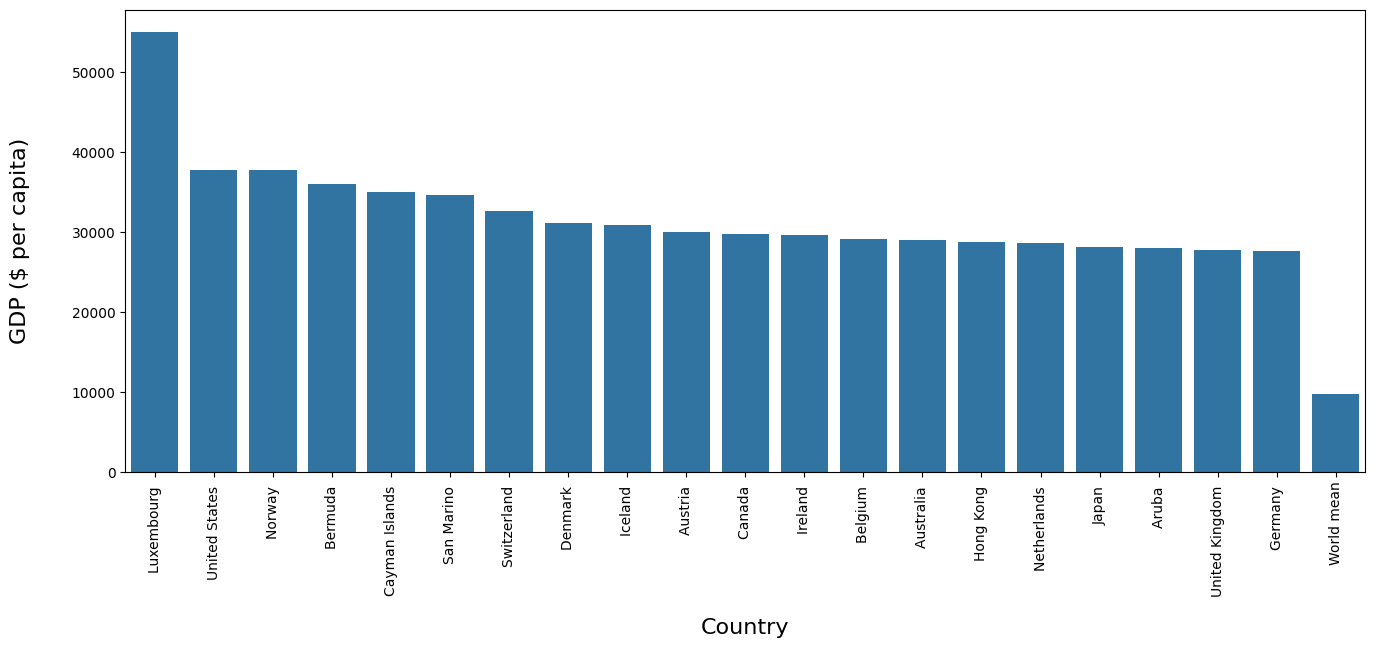

In [31]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(16, 6))
top_gdp_countries = data.sort_values('GDP ($ per capita)', ascending=False).head(20)
mean = pd.DataFrame({'Country': ['World mean'], 'GDP ($ per capita)': [data['GDP ($ per capita)'].mean()]})
gdps = pd.concat([top_gdp_countries[['Country', 'GDP ($ per capita)']], mean], ignore_index=True)

sns.barplot(x='Country', y='GDP ($ per capita)', data=gdps)
ax.set_xlabel(ax.get_xlabel(), labelpad=15)
ax.set_ylabel(ax.get_ylabel(), labelpad=30)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
plt.xticks(rotation=90)
plt.show()

warnings.filterwarnings('default')


Finding correlation between variables

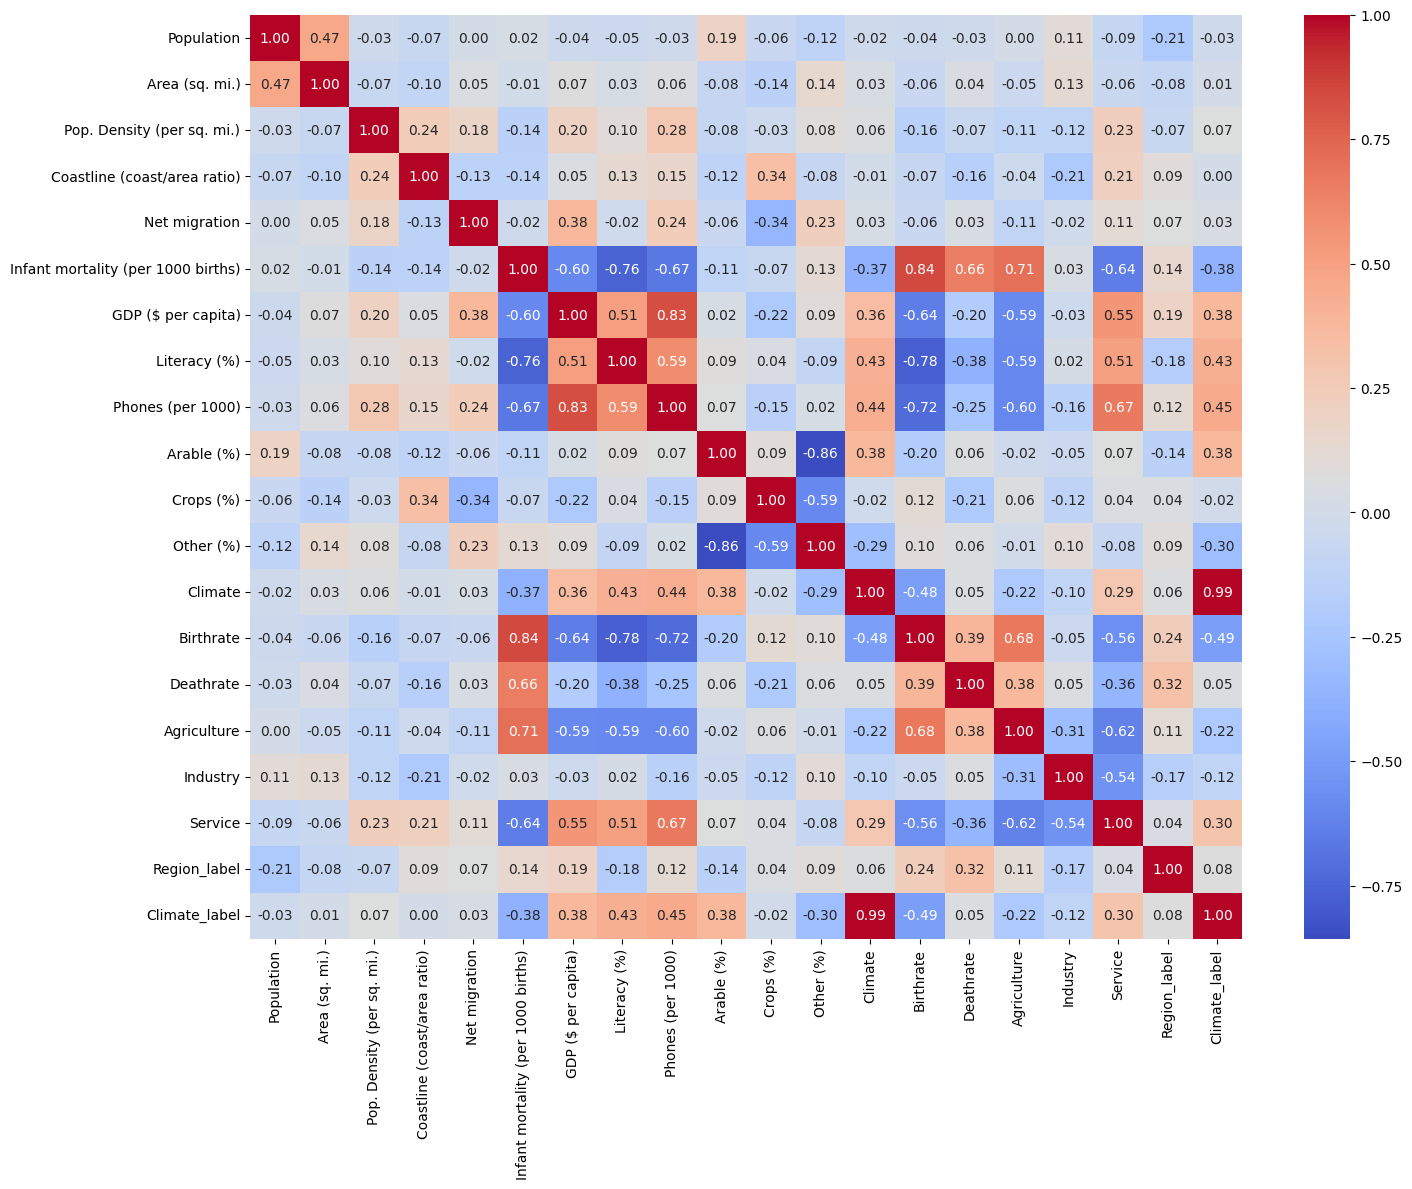

In [32]:
plt.figure(figsize=(16,12))
sns.heatmap(data=data.iloc[:,2:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

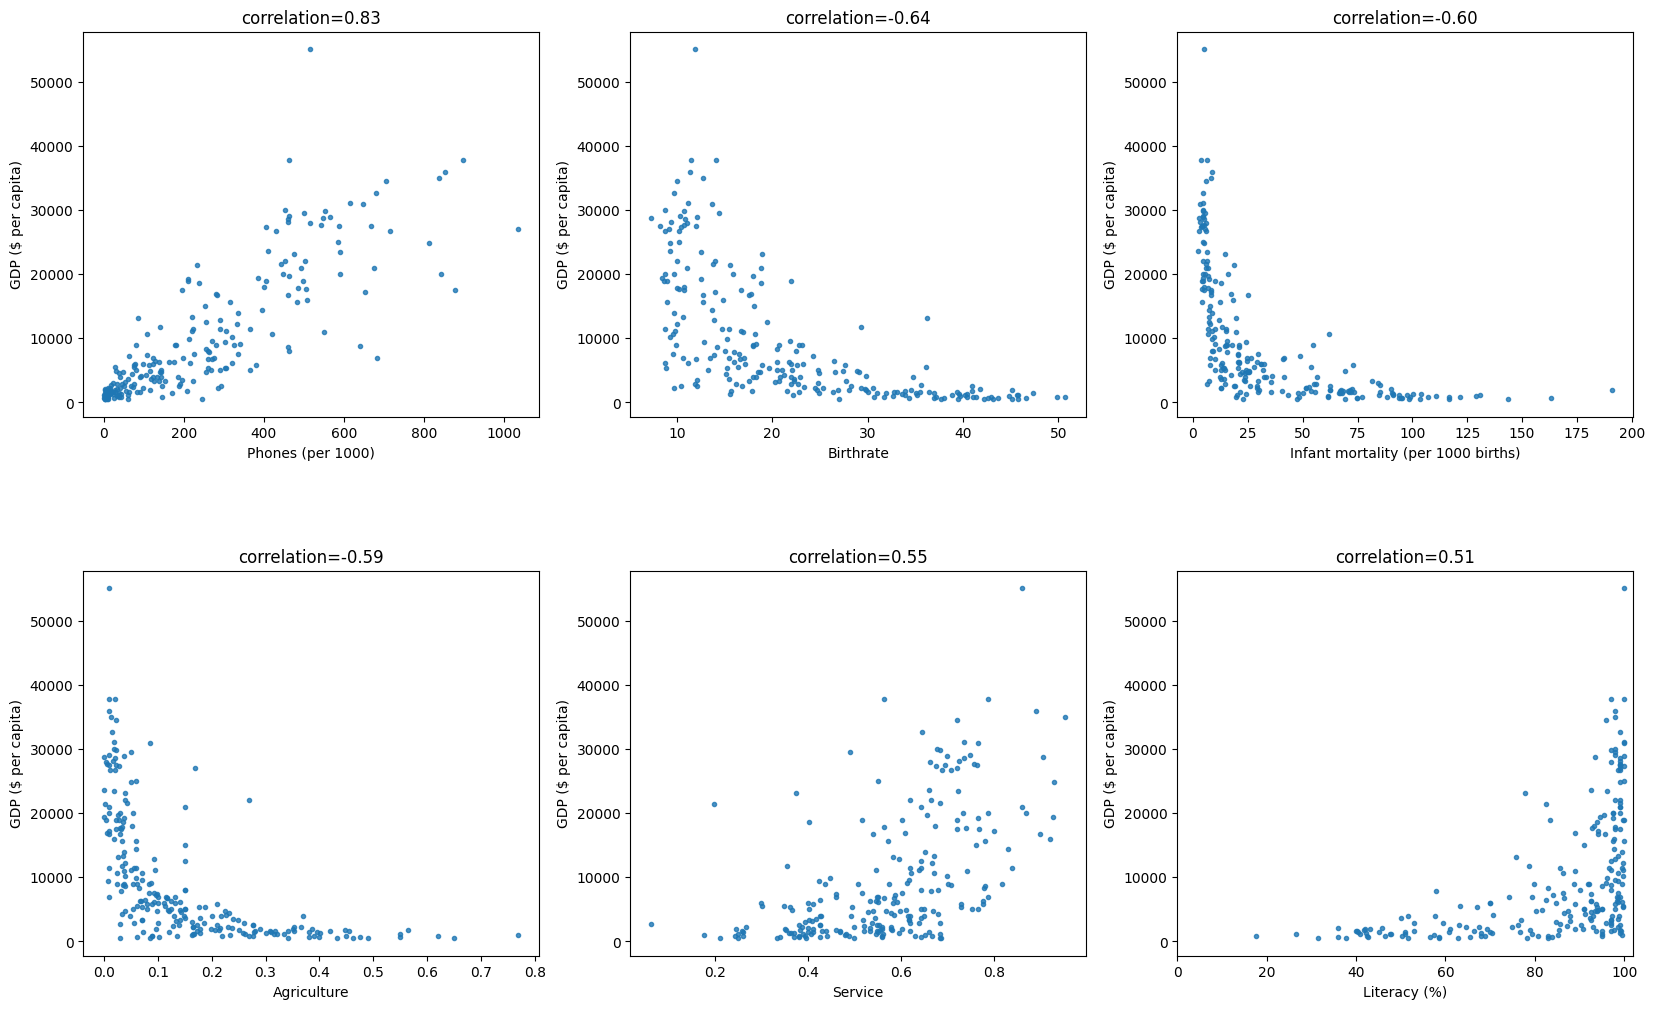

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

corr_to_gdp = pd.Series()
for col in data.columns.values[2:]:
    if col not in ['GDP ($ per capita)', 'Climate']:
        corr_to_gdp[col] = data['GDP ($ per capita)'].corr(data[col])

abs_corr_to_gdp = corr_to_gdp.abs().sort_values(ascending=False)
corr_to_gdp = corr_to_gdp.loc[abs_corr_to_gdp.index]

for i in range(2):
    for j in range(3):
        index = i*3 + j
        if index < len(corr_to_gdp):  # Check to ensure we don't exceed available columns
            sns.regplot(x=corr_to_gdp.index[index], y='GDP ($ per capita)', data=data,
                       ax=axes[i, j], fit_reg=False, marker='.')
            title = f'correlation={corr_to_gdp.iloc[index]:.2f}'  # Use .iloc to access position-based values
            axes[i, j].set_title(title)

axes[1, 2].set_xlim(0, 102)
plt.show()

# Splitting and Training the data

In [34]:
train, test = train_test_split(data, test_size=0.20, shuffle=True)
training_features = ['Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)','Net migration', 
       'Literacy (%)', 'Phones (per 1000)','Agriculture', 
       'Industry']
target = 'GDP ($ per capita)'
org_x=data[training_features]
org_y=data[target]
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

# Loading the model

In [35]:
model = LinearRegression()
model.fit(train_X, train_Y)
train_pred_Y = model.predict(train_X)
test_pred_Y = model.predict(test_X)
train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=train_Y.index)
test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=test_Y.index)


# Evaluating the model

In [36]:
rmse_train = np.sqrt(mean_squared_error(train_pred_Y, train_Y))
msle_train = mean_squared_log_error(train_pred_Y, train_Y)
rmse_test = np.sqrt(mean_squared_error(test_pred_Y, test_Y))
msle_test = mean_squared_log_error(test_pred_Y, test_Y)

print('rmse_train:',rmse_train,'msle_train:',msle_train)
print('rmse_test:',rmse_test,'msle_test:',msle_test)

rmse_train: 5190.009698520242 msle_train: 3.81006435446207
rmse_test: 4131.81377197208 msle_test: 8.258149045030194


In [37]:
model.score(train_X,train_pred_Y)

0.9970400138857082

In [38]:
model.score(test_X,test_pred_Y)

0.9972778621713727

# Model Result

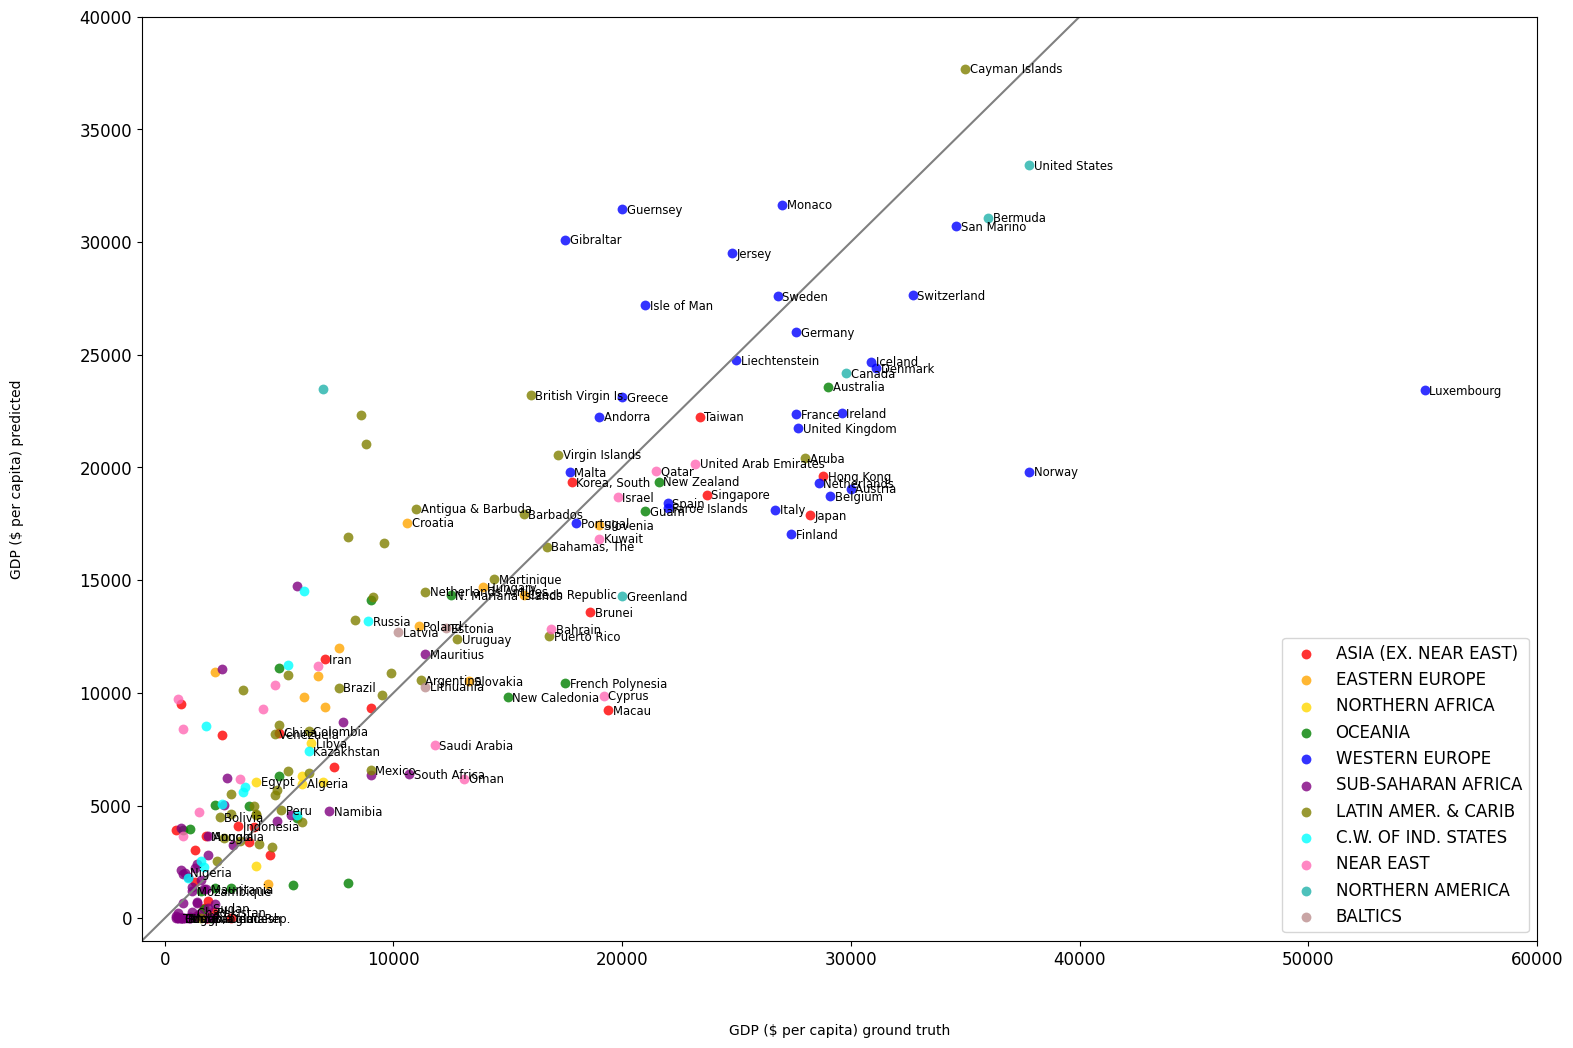

In [39]:
train_test_Y = pd.concat([train_Y, test_Y])
train_test_pred_Y = pd.concat([train_pred_Y, test_pred_Y])

data_shuffled = data.loc[train_test_Y.index]
label = data_shuffled['Country']

# Corrected colors dictionary with exact matches for 'Region'
colors = {
    'ASIA (EX. NEAR EAST)': 'red',
    'EASTERN EUROPE': 'orange',
    'NORTHERN AFRICA': 'gold',
    'OCEANIA': 'green',
    'WESTERN EUROPE': 'blue',
    'SUB-SAHARAN AFRICA': 'purple',
    'LATIN AMER. & CARIB': 'olive',
    'C.W. OF IND. STATES': 'cyan',
    'NEAR EAST': 'hotpink',
    'NORTHERN AMERICA': 'lightseagreen',
    'BALTICS': 'rosybrown'
}

plt.figure(figsize=(18, 12))

for region, color in colors.items():
    X = train_test_Y.loc[data_shuffled['Region'].str.strip() == region.strip()].values
    Y = train_test_pred_Y.loc[data_shuffled['Region'].str.strip() == region.strip()].values
    if X.size > 0 and Y.size > 0:  # Ensure X and Y are not empty
        sns.regplot(x=X, y=Y, marker='.', fit_reg=False, color=color, scatter_kws={'s': 200, 'linewidths': 0}, label=region)

plt.legend(loc=4, prop={'size': 12})

plt.xlabel('GDP ($ per capita) ground truth', labelpad=40)
plt.ylabel('GDP ($ per capita) predicted', labelpad=40)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(labelsize=12)

x = np.linspace(-1000, 50000, 100)  # 100 linearly spaced numbers
y = x
plt.plot(x, y, c='gray')

plt.xlim(-1000, 60000)
plt.ylim(-1000, 40000)

for i in range(0, train_test_Y.shape[0]):
    if ((data_shuffled['Area (sq. mi.)'].iloc[i] > 8e5) or
            (data_shuffled['Population'].iloc[i] > 1e8) or
            (data_shuffled['GDP ($ per capita)'].iloc[i] > 10000)):
        plt.text(train_test_Y.iloc[i] + 200, train_test_pred_Y.iloc[i] - 200, label.iloc[i], size='small')

plt.show()

# Deploying the model

In [42]:
model = LinearRegression()
model.fit(train_X, train_Y)

with open('GDP_Analysis_Regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved to 'GDP_Analysis.pkl'")

Model saved to 'GDP_Analysis.pkl'
